# Introduction
### The aim of this notebook is to compare a multi-output CNN model with three dedicated models in predicting age, gender and ethnicity of people from their photos. The dataset used for this task can be found [here](https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/codehttps://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/code)

# Importing libraries

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


# Data ingestion and exploration

In [216]:
data = pd.read_csv('/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')

In [205]:
data.sample(10)
# gender 0 is male, gender 1 is female

,age,ethnicity,gender,img_name,pixels
6858,26,3,1,20170104222823975.jpg.chip.jpg,"[[[0.3019608], [0.21176471], [0.16862746], [0...."
22549,78,2,0,20170112205258396.jpg.chip.jpg,"[[[0.12156863], [0.15294118], [0.18039216], [0..."
12239,32,0,0,20170117010455142.jpg.chip.jpg,"[[[0.03529412], [0.05490196], [0.05882353], [0..."
18008,5,0,1,20170109194229104.jpg.chip.jpg,"[[[0.023529412], [0.06666667], [0.047058824], ..."
14038,36,4,1,20170117180642329.jpg.chip.jpg,"[[[0.81960785], [0.81960785], [0.80784315], [0..."
23,1,2,0,20161219221908887.jpg.chip.jpg,"[[[0.15294118], [0.23529412], [0.24313726], [0..."
19333,54,0,0,20170105173228717.jpg.chip.jpg,"[[[0.5294118], [0.4862745], [0.49411765], [0.6..."
17298,46,3,0,20170119195012113.jpg.chip.jpg,"[[[0.54901963], [0.5882353], [0.6117647], [0.6..."
10233,29,0,0,20170117180857403.jpg.chip.jpg,"[[[0.17254902], [0.039215688], [0.050980393], ..."
3499,21,3,1,20170117142239360.jpg.chip.jpg,"[[[0.7372549], [0.5058824], [0.31764707], [0.3..."


In [218]:
data.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


In [221]:
data.mode()

,age,ethnicity,gender,pixels
0,26,0,0,10 21 33 31 42 54 66 75 73 73 80 87 91 96 102 ...


In [213]:
data["ethnicity"].unique()

array([2, 3, 4, 0, 1])

In [4]:
print(f'Total rows: {format(len(data))}')
print(f'Total columns: {format(len(data.columns))}')

Total rows: 23705
Total columns: 5


In [5]:
data.columns

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')

In [217]:
data = data.drop('img_name', axis=1) # image name won't be usefull in this case

In [6]:
## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [7]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

In [8]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

there exists a dominant class, I won't try balancing them 

In [9]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

Gender class balance is ok

# hyperparameter and callback definition

In [144]:
epochs = 50
batch_size = 64
# Setting up the EarlyStopping callback
my_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Data preprocessing

In [11]:
# Converting and reshaping images from the dataset, normalizing pixel data
data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))  # convert to array
data['pixels'] = data['pixels'].apply(lambda x: x.reshape(48, 48, 1))  # reshape to image format
data['pixels'] = data['pixels'].apply(lambda x: x/255) # normalize pixel values


In [12]:
# Splitting the DataFrame into training, validation and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [13]:
# extracting and naming data for the respective tasks
train_images = np.array(train_df['pixels'].tolist())
train_ages = train_df['age'].values
train_genders = train_df['gender'].values
train_ethnicities = train_df['ethnicity'].values

val_images = np.array(val_df['pixels'].tolist())
val_ages = val_df['age'].values
val_genders = val_df['gender'].values
val_ethnicities = val_df['ethnicity'].values

test_images = np.array(test_df['pixels'].tolist())
test_ages = test_df['age'].values
test_genders = test_df['gender'].values
test_ethnicities = test_df['ethnicity'].values

In [14]:
train_images.shape

(14223, 48, 48, 1)

## Ethnicity column inspection

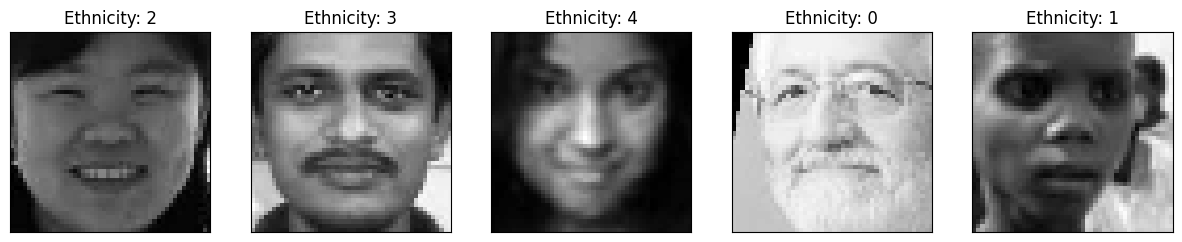

In [15]:
unique_ethnicities = data['ethnicity'].unique()

plt.figure(figsize=(15, 15))

for i, ethnicity in enumerate(unique_ethnicities):
    # Get all indices of the current ethnicity class
    indices = data[data['ethnicity'] == ethnicity].index
    # Choose a random index from these indices
    random_idx = np.random.choice(indices)
    img = data['pixels'].iloc[random_idx].reshape(48, 48)

    # Plotting
    plt.subplot(1, len(unique_ethnicities), i + 1)  # Adjust the subplot grid as needed
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')
    plt.title(f"Ethnicity: {ethnicity}")

plt.show()


I am not sure to what exact labels the numbers 0-4 correspond to however classes are visually differentiable

# Baseline mulit-output model

In [174]:
num_ethnicity_classes=5

# Shared layers
input_layer = layers.Input(shape=(48, 48, 1))

x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.35)(x)

# Branch for age prediction
age_output = Dense(1, name='age_output')(x)  # Assuming age is a regression task

# Branch for gender prediction
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# Branch for ethnicity prediction
ethnicity_output = Dense(num_ethnicity_classes, name='ethnicity_output')(x)

# Create model
model = Model(inputs=input_layer, outputs=[age_output, gender_output, ethnicity_output])

# Compile model with multiple loss functions
model.compile(optimizer='adam',
              loss={'age_output': 'mse',  # Mean Squared Error for regression
                    'gender_output': 'binary_crossentropy',
                    'ethnicity_output': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
              metrics={'age_output': ['mae'],  # Mean Absolute Error for age
                       'gender_output': ['accuracy'],
                       'ethnicity_output': ['accuracy']})

# model.summary()


In [175]:
# baseline model training
history = model.fit(
    x=train_images,
    y={'age_output': train_ages, 'gender_output': train_genders, 'ethnicity_output': train_ethnicities},
    validation_data=(val_images, {'age_output': val_ages, 'gender_output': val_genders, 'ethnicity_output': val_ethnicities}),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[my_callback]
)

Epoch 1/50


2023-12-29 12:48:52.106453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


223/223 [==============================] - 6s 13ms/step - loss: 379.6934 - age_output_loss: 376.7948 - gender_output_loss: 0.8853 - ethnicity_output_loss: 2.0131 - age_output_mae: 14.8208 - gender_output_accuracy: 0.5713 - ethnicity_output_accuracy: 0.3462 - val_loss: 230.9801 - val_age_output_loss: 229.0686 - val_gender_output_loss: 0.5795 - val_ethnicity_output_loss: 1.3320 - val_age_output_mae: 11.2435 - val_gender_output_accuracy: 0.7159 - val_ethnicity_output_accuracy: 0.5071
Epoch 2/50
223/223 [==============================] - 3s 11ms/step - loss: 234.2660 - age_output_loss: 232.0178 - gender_output_loss: 0.6636 - ethnicity_output_loss: 1.5846 - age_output_mae: 11.5698 - gender_output_accuracy: 0.6747 - ethnicity_output_accuracy: 0.4432 - val_loss: 240.3701 - val_age_output_loss: 238.4874 - val_gender_output_loss: 0.5423 - val_ethnicity_output_loss: 1.3404 - val_age_output_mae: 11.6349 - val_gender_output_accuracy: 0.7477 - val_ethnicity_output_accuracy: 0.5292
Epoch 3/50
223/22

# Plotting model history

In [136]:
def PlotModelHistory(history):
    metrics = set()  # To store unique metrics excluding 'loss' and 'val_loss'
    for key in history.history.keys():
        if 'loss' not in key:
            # Extracting metric name (excluding 'val_' prefix)
            metrics.add(key.replace('val_', ''))

    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics + 1, figsize=(5 * (num_metrics + 1), 5))

    # Plotting loss
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='validate')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper right')

    # Plotting other metrics
    for i, metric in enumerate(sorted(metrics)):  # Sorting for consistent ordering
        axs[i + 1].plot(history.history[metric], label=f'train_{metric}')
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            axs[i + 1].plot(history.history[val_metric], label=f'validate_{metric}')
        axs[i + 1].set_title(f'Model {metric.capitalize()}')
        axs[i + 1].set_ylabel(metric.capitalize())
        axs[i + 1].set_xlabel('Epoch')
        axs[i + 1].legend(loc='lower left')

    plt.tight_layout()
    plt.show()

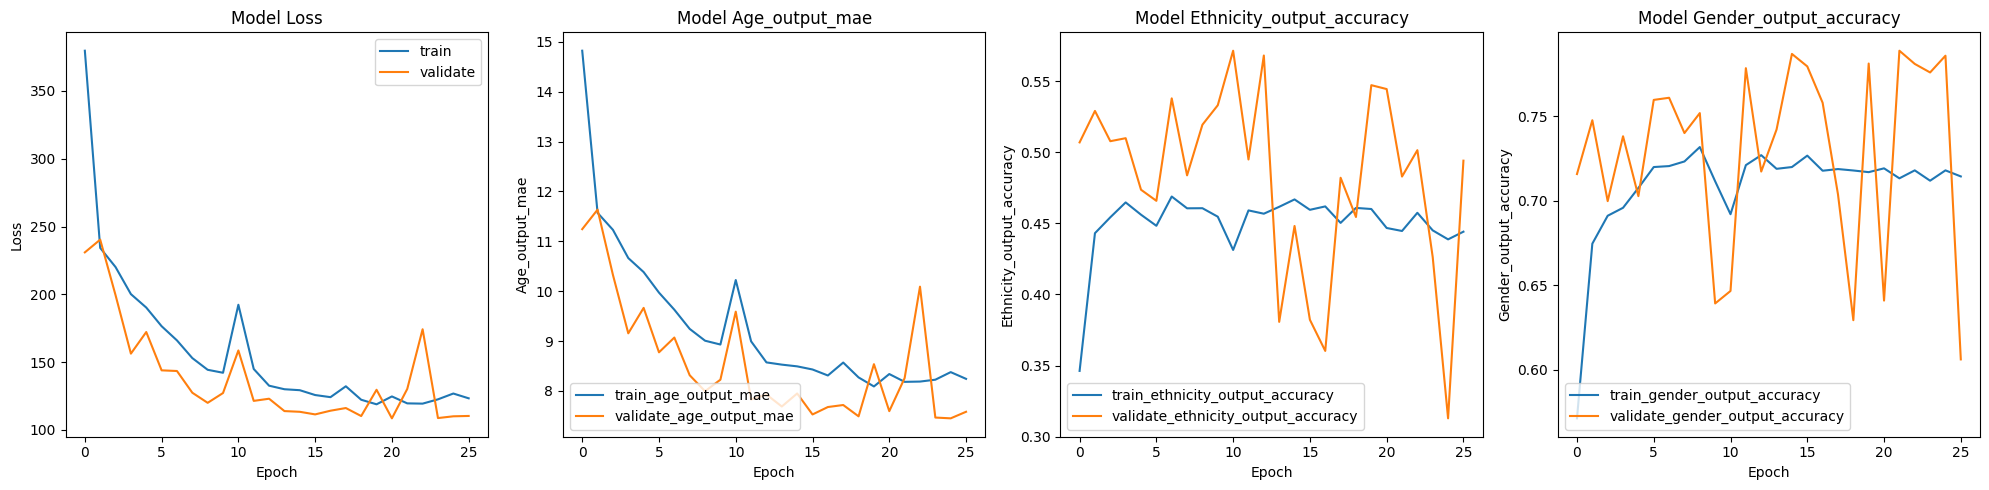

In [176]:
PlotModelHistory(history)
# history.history.keys()

# Baseline model evaluation

In [177]:
test_loss, test_age_loss, test_gender_loss, test_ethnicity_loss, test_age_mae, test_gender_accuracy, test_ethnicity_accuracy = model.evaluate(
    test_images,
    {'age_output': test_ages, 'gender_output': test_genders, 'ethnicity_output': test_ethnicities}, verbose=1
)


149/149 [==============================] - 1s 4ms/step - loss: 107.0900 - age_output_loss: 104.8821 - gender_output_loss: 0.8307 - ethnicity_output_loss: 1.3771 - age_output_mae: 7.5284 - gender_output_accuracy: 0.6429 - ethnicity_output_accuracy: 0.5381


## further evaluation 


In [178]:
print(f"Total Test Loss: {test_loss:.4f}")
print(f"Age Test Loss: {test_age_loss:.4f}, Age Test MAE: {test_age_mae:.4f}")
print(f"Gender Test Loss: {test_gender_loss:.4f}, Gender Test Accuracy: {test_gender_accuracy:.4f}")
print(f"Ethnicity Test Loss: {test_ethnicity_loss:.4f}, Ethnicity Test Accuracy: {test_ethnicity_accuracy:.4f}")


Total Test Loss: 107.0900
Age Test Loss: 104.8821, Age Test MAE: 7.5284
Gender Test Loss: 0.8307, Gender Test Accuracy: 0.6429
Ethnicity Test Loss: 1.3771, Ethnicity Test Accuracy: 0.5381


In [179]:
sample_image = test_images[0]
sample_image = sample_image.reshape(1, 48, 48, 1)  # Reshape to match the model's input shape


In [181]:
predictions = model.predict(sample_image)


1/1 [==============================] - 0s 19ms/step


In [182]:
age_prediction = predictions[0][0][0]  # Extract age prediction
gender_prediction = 1 if predictions[1][0][0] > 0.5 else 0  # Binary classification (e.g., 1 for male, 0 for female)
ethnicity_prediction = np.argmax(predictions[2][0])  # Class with highest probability

print(f"Predicted Age: {age_prediction}")
print(f"Predicted Gender: {'Male' if gender_prediction == 1 else 'Female'}")
print(f"Predicted Ethnicity: {ethnicity_prediction}")  # Interpret based on your class labels


Predicted Age: 24.510007858276367
Predicted Gender: Male
Predicted Ethnicity: 0


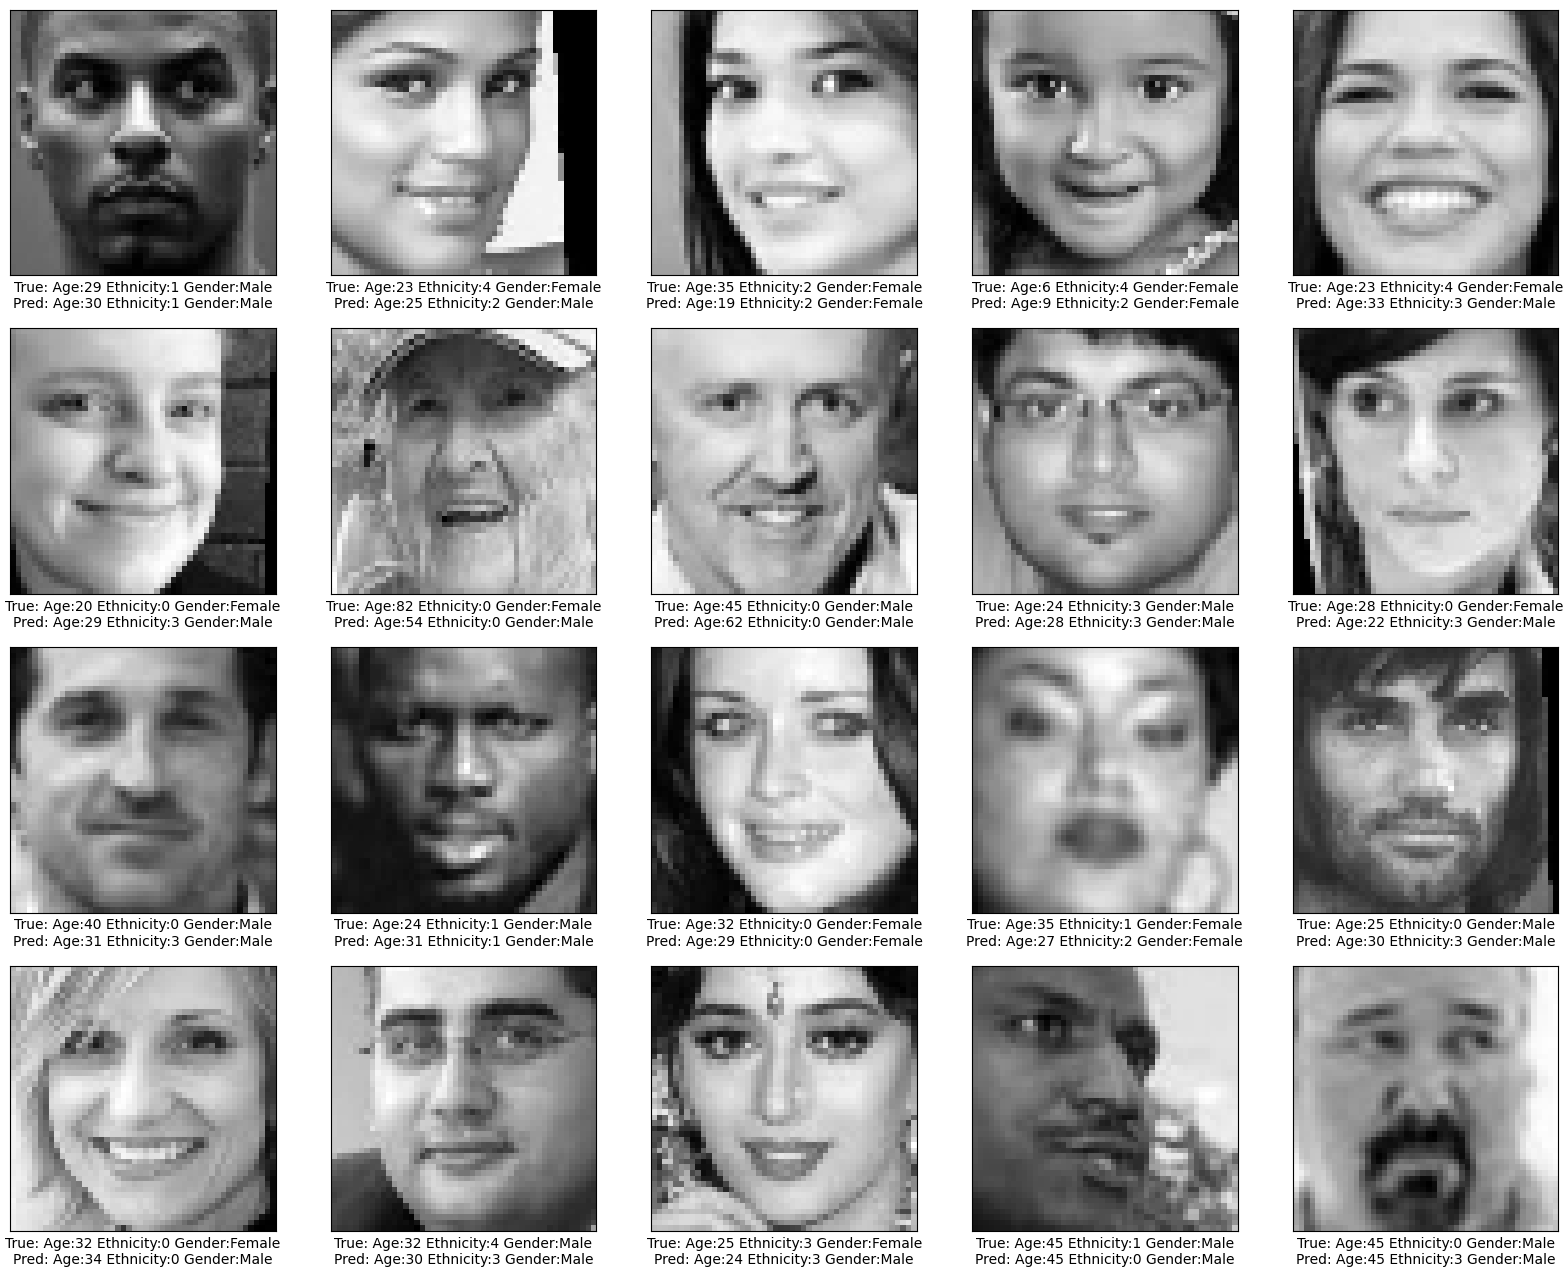

In [183]:
# Define the number of images to display
num_images = 20
start_index = 1600  # Adjust this index to choose different images from the test set

plt.figure(figsize=(20, 20))

for i in range(num_images):
    idx = start_index + i
    img = test_images[idx].reshape(1, 48, 48, 1)

    # Making predictions
    predictions = model.predict(img, verbose=0)
    age_pred = predictions[0][0][0]  # Age prediction
    gender_pred = 1 if predictions[1][0][0] > 0.5 else 0  # Gender prediction
    ethnicity_pred = np.argmax(predictions[2][0])  # Ethnicity prediction

    # Determine true gender label
    true_gender_label = 'Female' if test_genders[idx] == 1 else 'Male'

    # Plotting
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[idx].reshape(48, 48), cmap='gray')
    plt.xlabel(
        f"True: Age:{test_ages[idx]} Ethnicity:{test_ethnicities[idx]} Gender:{true_gender_label}\n" +
        f"Pred: Age:{int(age_pred)} Ethnicity:{ethnicity_pred} Gender:{'Female' if gender_pred == 1 else 'Male'}"
    )

plt.show()


In [222]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_152 (Conv2D)         (None, 48, 48, 32)           320       ['input_38[0][0]']            
                                                                                                  
 conv2d_153 (Conv2D)         (None, 46, 46, 32)           9248      ['conv2d_152[0][0]']          
                                                                                                  
 max_pooling2d_98 (MaxPooli  (None, 23, 23, 32)           0         ['conv2d_153[0][0]']          
 ng2D)                                                                                     

# Ethnicty prediction dedicated model

In [68]:
model_eth = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(num_ethnicity_classes)
])

model_eth.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model_eth.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 6400)              0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [69]:
history_model_eth = model_eth.fit(train_images, train_ethnicities,
                            epochs=epochs,
                            validation_data=(val_images, val_ethnicities),
                            batch_size=batch_size,
                            callbacks=[my_callback]
)

Epoch 1/50
223/223 [==============================] - 3s 6ms/step - loss: 1.2842 - accuracy: 0.5087 - val_loss: 1.0291 - val_accuracy: 0.6313
Epoch 2/50
223/223 [==============================] - 1s 5ms/step - loss: 1.0310 - accuracy: 0.6280 - val_loss: 0.8863 - val_accuracy: 0.7091
Epoch 3/50
223/223 [==============================] - 1s 5ms/step - loss: 0.9368 - accuracy: 0.6691 - val_loss: 0.8419 - val_accuracy: 0.6963
Epoch 4/50
223/223 [==============================] - 1s 5ms/step - loss: 0.8967 - accuracy: 0.6835 - val_loss: 0.7705 - val_accuracy: 0.7271
Epoch 5/50
223/223 [==============================] - 1s 5ms/step - loss: 0.8789 - accuracy: 0.6845 - val_loss: 0.7640 - val_accuracy: 0.7368
Epoch 6/50
223/223 [==============================] - 1s 5ms/step - loss: 0.8333 - accuracy: 0.7107 - val_loss: 0.7797 - val_accuracy: 0.7319
Epoch 7/50
223/223 [==============================] - 1s 5ms/step - loss: 0.8161 - accuracy: 0.7144 - val_loss: 0.7298 - val_accuracy: 0.7486
Epoch 

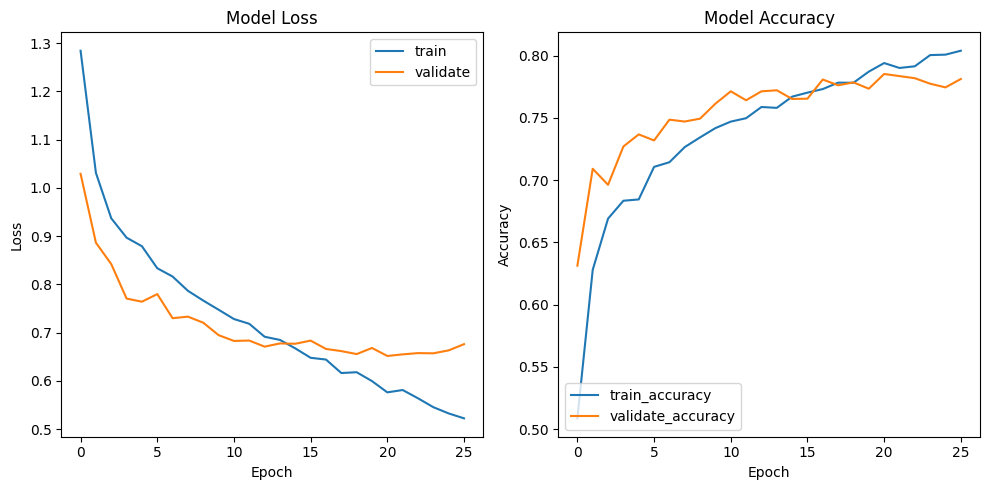

In [184]:
PlotModelHistory(history_model_eth)

Signs of best possible fit around epoch 12

## Alternative ethnicity prediction model

In [191]:
num_ethnicity_classes = 5  

model_eth_2 = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 1)),

    # Increasing the complexity by adding more convolutional layers and filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    # Increasing the number of neurons in the dense layer
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.15),
    # Output layer
    layers.Dense(num_ethnicity_classes)
])

model_eth_2.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_eth_2.summary()


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_172 (Conv2D)         (None, 48, 48, 32)        320       
                                                                 
 conv2d_173 (Conv2D)         (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_108 (MaxPool  (None, 24, 24, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_174 (Conv2D)         (None, 24, 24, 64)        18496     
                                                                 
 conv2d_175 (Conv2D)         (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_109 (MaxPool  (None, 12, 12, 64)        0         
 ing2D)                                              

In [192]:
history_model_eth_2 = model_eth_2.fit(train_images, train_ethnicities,
                            epochs=epochs,
                            validation_data=(val_images, val_ethnicities),
                            batch_size=batch_size,
                            callbacks=[my_callback]
)

Epoch 1/50
223/223 [==============================] - 7s 13ms/step - loss: 1.3913 - accuracy: 0.4536 - val_loss: 1.5131 - val_accuracy: 0.5628
Epoch 2/50
223/223 [==============================] - 3s 11ms/step - loss: 1.1017 - accuracy: 0.6025 - val_loss: 2.1049 - val_accuracy: 0.6539
Epoch 3/50
223/223 [==============================] - 3s 11ms/step - loss: 1.1601 - accuracy: 0.6504 - val_loss: 5.5600 - val_accuracy: 0.6663
Epoch 4/50
223/223 [==============================] - 3s 11ms/step - loss: 1.0722 - accuracy: 0.6307 - val_loss: 40.0689 - val_accuracy: 0.6581
Epoch 5/50
223/223 [==============================] - 3s 11ms/step - loss: 1.0989 - accuracy: 0.5887 - val_loss: 36.9637 - val_accuracy: 0.5891
Epoch 6/50
223/223 [==============================] - 3s 11ms/step - loss: 1.0226 - accuracy: 0.6209 - val_loss: 27.0165 - val_accuracy: 0.6292
Epoch 6: early stopping


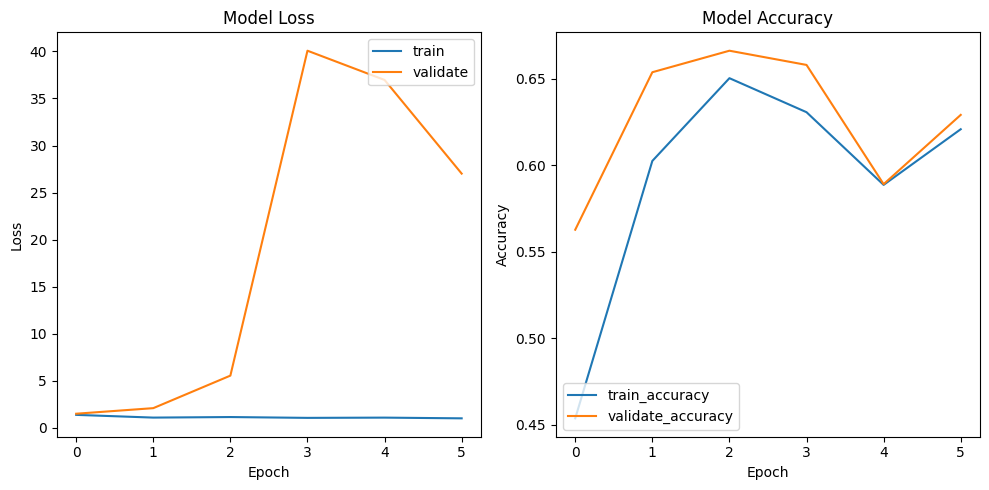

In [193]:
PlotModelHistory(history_model_eth_2)

The model is much less stable than the previous model

## Ethnicity model comparison

In [194]:
model_eth_metrics = model_eth.evaluate(test_images, test_ethnicities)

149/149 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.7730


In [195]:
model_eth_2_metrics = model_eth_2.evaluate(test_images, test_ethnicities)

149/149 [==============================] - 1s 3ms/step - loss: 2.9665 - accuracy: 0.1426


In [62]:
if model_eth_metrics[1] > model_eth_2_metrics[1]:
    model_eth = model_eth
    print("First dedicated ethnicity prediction model performed better")
else:
    model_eth = model_eth_2
    print("Second dedicated ethnicity prediction model performed better")


First dedicated ethnicity prediction model performed better


# Gender prediction dedicated model

In [118]:
model_gender = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(1, activation='sigmoid')
])

model_gender.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_gender.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_30 (Ba  (None, 46, 46, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_65 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                     

In [119]:
history_model_gender = model_gender.fit(
    train_images, train_genders,
    epochs=epochs,
    validation_data=(val_images, val_genders),
    batch_size=batch_size,
    callbacks=[my_callback]
)

Epoch 1/50
223/223 [==============================] - 2s 7ms/step - loss: 0.5496 - accuracy: 0.7219 - val_loss: 0.6391 - val_accuracy: 0.5900
Epoch 2/50
223/223 [==============================] - 1s 5ms/step - loss: 0.4281 - accuracy: 0.8097 - val_loss: 0.4631 - val_accuracy: 0.8249
Epoch 3/50
223/223 [==============================] - 1s 5ms/step - loss: 0.3812 - accuracy: 0.8278 - val_loss: 0.3660 - val_accuracy: 0.8380
Epoch 4/50
223/223 [==============================] - 1s 5ms/step - loss: 0.3532 - accuracy: 0.8463 - val_loss: 0.4006 - val_accuracy: 0.8043
Epoch 5/50
223/223 [==============================] - 1s 5ms/step - loss: 0.3316 - accuracy: 0.8519 - val_loss: 0.3183 - val_accuracy: 0.8576
Epoch 6/50
223/223 [==============================] - 1s 5ms/step - loss: 0.3210 - accuracy: 0.8586 - val_loss: 0.4180 - val_accuracy: 0.7830
Epoch 7/50
223/223 [==============================] - 1s 5ms/step - loss: 0.3076 - accuracy: 0.8613 - val_loss: 0.3026 - val_accuracy: 0.8627
Epoch 

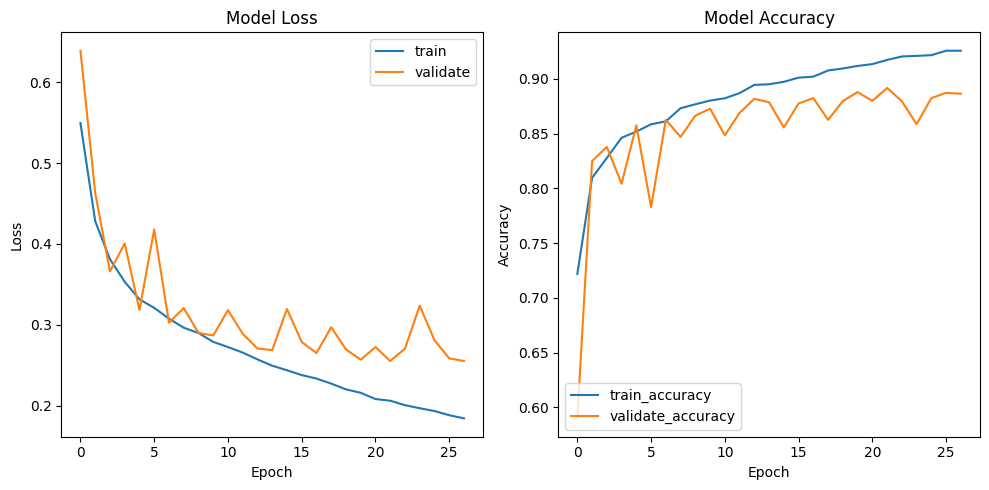

In [120]:
PlotModelHistory(history_model_gender)

Semi stable loss values around epoch ~ 12

## Alternative gender prediction dedicated model

In [121]:
from keras import initializers

model_gender_2 = models.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),

    layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer=initializers.HeNormal()),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer=initializers.HeNormal()),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer=initializers.HeNormal()),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='elu', kernel_initializer=initializers.HeNormal()),
    layers.Dropout(rate=0.5),
    layers.Dense(1, activation='sigmoid')
])

model_gender_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gender_2.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_31 (Ba  (None, 46, 46, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_94 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_32 (Ba  (None, 21, 21, 64)        256       
 tchNormalization)                                               
                                                     

In [122]:
history_model_gender_2 = model_gender_2.fit(
    train_images, train_genders,
    epochs=epochs,
    validation_data=(val_images, val_genders),
    batch_size=16,
    callbacks=[my_callback]
)

Epoch 1/50
889/889 [==============================] - 8s 6ms/step - loss: 0.4783 - accuracy: 0.7950 - val_loss: 0.3284 - val_accuracy: 0.8517
Epoch 2/50
889/889 [==============================] - 5s 5ms/step - loss: 0.3134 - accuracy: 0.8599 - val_loss: 0.3038 - val_accuracy: 0.8553
Epoch 3/50
889/889 [==============================] - 5s 6ms/step - loss: 0.2604 - accuracy: 0.8829 - val_loss: 0.3051 - val_accuracy: 0.8644
Epoch 4/50
889/889 [==============================] - 5s 5ms/step - loss: 0.2316 - accuracy: 0.9011 - val_loss: 0.2889 - val_accuracy: 0.8766
Epoch 5/50
889/889 [==============================] - 5s 5ms/step - loss: 0.2049 - accuracy: 0.9143 - val_loss: 0.2582 - val_accuracy: 0.8861
Epoch 6/50
889/889 [==============================] - 5s 5ms/step - loss: 0.1792 - accuracy: 0.9236 - val_loss: 0.2683 - val_accuracy: 0.8846
Epoch 7/50
889/889 [==============================] - 5s 5ms/step - loss: 0.1514 - accuracy: 0.9371 - val_loss: 0.3331 - val_accuracy: 0.8825
Epoch 

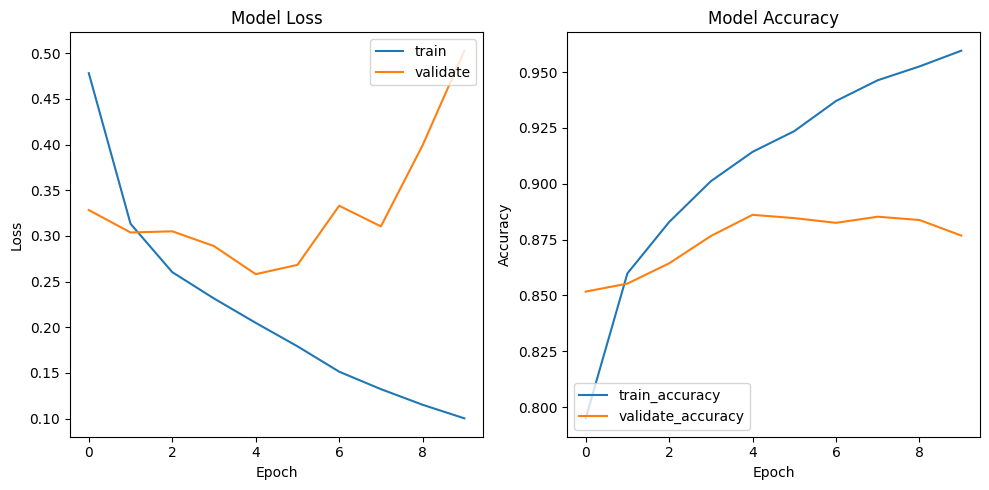

In [196]:
PlotModelHistory(history_model_gender_2)

clear signs of overfitting in the training dataset, training loss decreases while validation loss increases through the epochs

## Gender model comparison

In [123]:
model_gender_metrics = model_gender.evaluate(test_images, test_genders)
model_gender_2_metrics = model_gender_2.evaluate(test_images, test_genders)

149/149 [==============================] - 0s 3ms/step - loss: 0.2524 - accuracy: 0.8931


In [124]:
if model_gender_metrics[1] > model_gender_2_metrics[1]:
    model_gender = model_gender
    print("First dedicated gender prediction model performed better")
else:
    model_gender = model_gender_2
    print("Second dedicated gender prediction model performed better")


Second dedicated gender prediction model performed better


# Age prediction dedicated model

In [87]:
model_age = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(1, activation='relu')
])

# sgd = tf.keras.optimizers.SGD(momentum=0.9)

model_age.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

model_age.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_5 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_65 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                     

In [88]:
history_model_age = model_age.fit(
    train_images, train_ages,
    epochs=epochs,
    validation_data=(val_images, val_ages),
    batch_size=batch_size,
    callbacks = [my_callback]
)

Epoch 1/50
223/223 [==============================] - 4s 7ms/step - loss: 370.0909 - mae: 14.7309 - val_loss: 1122.0858 - val_mae: 27.6583
Epoch 2/50
223/223 [==============================] - 1s 6ms/step - loss: 217.8624 - mae: 11.1708 - val_loss: 858.1999 - val_mae: 23.8408
Epoch 3/50
223/223 [==============================] - 1s 6ms/step - loss: 193.3727 - mae: 10.4410 - val_loss: 253.3501 - val_mae: 11.5505
Epoch 4/50
223/223 [==============================] - 1s 6ms/step - loss: 171.8746 - mae: 9.7851 - val_loss: 195.4290 - val_mae: 10.4026
Epoch 5/50
223/223 [==============================] - 1s 6ms/step - loss: 164.5029 - mae: 9.5160 - val_loss: 107.0959 - val_mae: 7.6316
Epoch 6/50
223/223 [==============================] - 1s 6ms/step - loss: 154.2287 - mae: 9.2351 - val_loss: 317.8612 - val_mae: 13.9347
Epoch 7/50
223/223 [==============================] - 1s 6ms/step - loss: 154.2278 - mae: 9.2275 - val_loss: 160.5589 - val_mae: 9.1613
Epoch 8/50
223/223 [===================

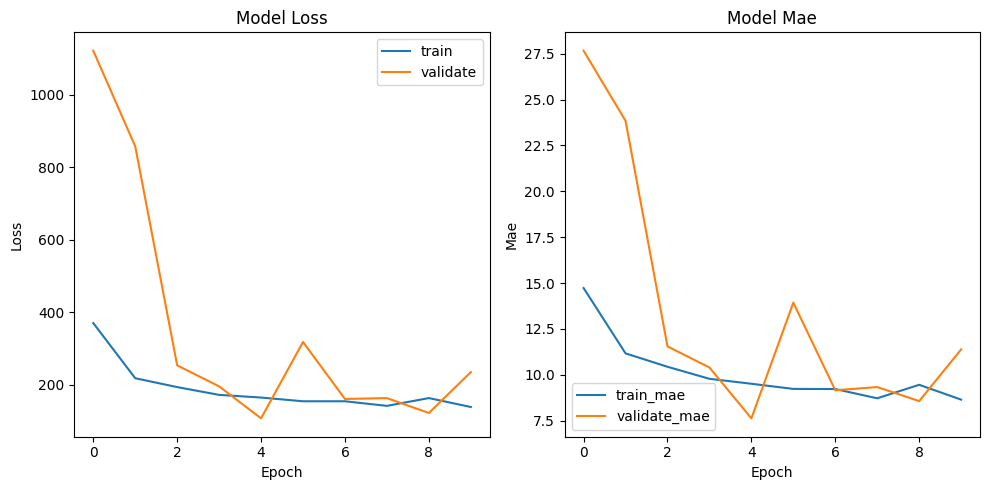

In [89]:
PlotModelHistory(history_model_age)

The model fits properly right about epoch 3

## Alternative age prediction dedicated model

In [111]:
from keras.regularizers import l1_l2

model_age_2 = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='elu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='elu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='elu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='elu'),
    layers.Dropout(rate=0.25),
    layers.Dense(1)
])

model_age_2.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

model_age_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_24 (Ba  (None, 46, 46, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_25 (Ba  (None, 21, 21, 64)        256       
 tchNormalization)                                               
                                                     

In [112]:
# checkpoint_filepath = '/content/tmp/checkpoint'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
#                     monitor="val_loss", mode="min",
#                     save_best_only=True, verbose=1)

In [113]:
history_model_age_2 = model_age_2.fit(
    train_images, train_ages,
    epochs=epochs,
    validation_data=(val_images, val_ages),
    batch_size=16,
    callbacks = [my_callback]
)

Epoch 1/50
889/889 [==============================] - 8s 5ms/step - loss: 194.7152 - mae: 10.4144 - val_loss: 462.4663 - val_mae: 16.0013
Epoch 2/50
889/889 [==============================] - 4s 5ms/step - loss: 124.1127 - mae: 8.3232 - val_loss: 282.1840 - val_mae: 11.9714
Epoch 3/50
889/889 [==============================] - 5s 5ms/step - loss: 104.6584 - mae: 7.5816 - val_loss: 148.0055 - val_mae: 9.2607
Epoch 4/50
889/889 [==============================] - 5s 5ms/step - loss: 91.1007 - mae: 7.1494 - val_loss: 141.4442 - val_mae: 8.5360
Epoch 5/50
889/889 [==============================] - 5s 5ms/step - loss: 82.8089 - mae: 6.8300 - val_loss: 247.2310 - val_mae: 11.0441
Epoch 6/50
889/889 [==============================] - 5s 5ms/step - loss: 72.3860 - mae: 6.4159 - val_loss: 591.7916 - val_mae: 20.3607
Epoch 7/50
889/889 [==============================] - 5s 5ms/step - loss: 66.2005 - mae: 6.1712 - val_loss: 88.8181 - val_mae: 6.9667
Epoch 8/50
889/889 [============================

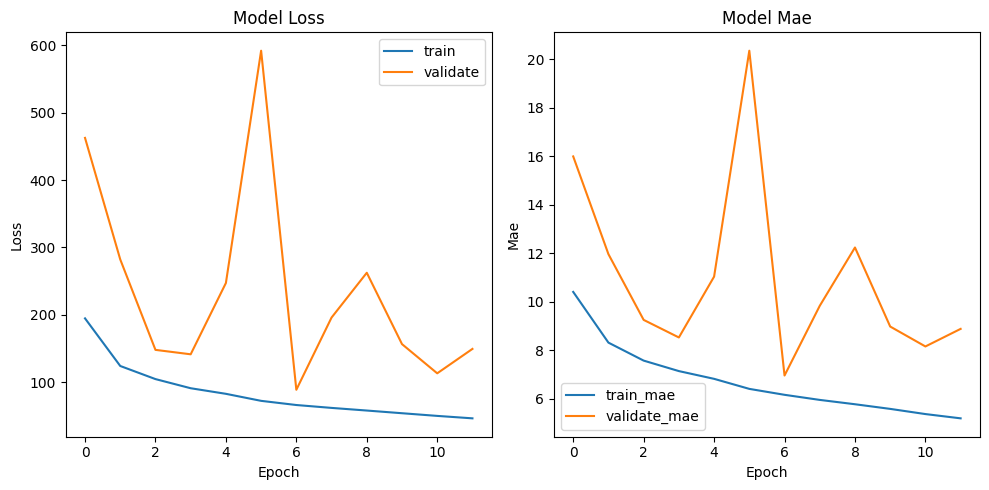

In [114]:
PlotModelHistory(history_model_age_2)

Model fits properly to the training dataset however results on validation dataset are pretty chaotic

In [ ]:
# model_age_2.load_weights('/content/tmp/checkpoint/')

## Age model comparison

In [115]:
model_age_metrics = model_age.evaluate(test_images, test_ages)
model_age_metrics_2 = model_age_2.evaluate(test_images, test_ages)

149/149 [==============================] - 0s 3ms/step - loss: 91.6511 - mae: 7.0615


In [126]:
if model_age_metrics[1] < model_gender_2_metrics[1]:
    model_age = model_age
    print("First dedicated age prediction model performed better")
else:
    model_age = model_age_2
    print("Second dedicated age prediction model performed better")


Second dedicated age prediction model performed better


# Comparing the models

In [127]:
# assembling a list of the best dedicated models for each tasks out of their respective pairs 
dedicated_models = [model_age, model_gender, model_eth]


In [198]:
def evaluate_and_compare_models(dedicated_models, multi_model, test_data):
    # Unpack the test data
    test_images, test_ages, test_genders, test_ethnicities = test_data

    # Evaluate dedicated models
    dedicated_results = {}
    dedicated_results['age'] = dedicated_models[0].evaluate(test_images, test_ages, verbose=0)
    dedicated_results['gender'] = dedicated_models[1].evaluate(test_images, test_genders, verbose=0)
    dedicated_results['ethnicity'] = dedicated_models[2].evaluate(test_images, test_ethnicities, verbose=0)

    # Evaluate multi-output model
    multi_results = multi_model.evaluate(
        test_images,
        {'age_output': test_ages, 'gender_output': test_genders, 'ethnicity_output': test_ethnicities},
        verbose=0
    )

    # Print results
    print("Dedicated Models Results:")
    for task, result in dedicated_results.items():
        print(f" {task.capitalize()} Model - Loss: {result[0]:.4f}, Accuracy: {result[1]:.4f}")

    print("\nMulti-Output Model Results:")
    print(f" Overall Loss: {multi_results[0]:.4f}")
    print(f" Age - Loss: {multi_results[1]:.4f}, MAE: {multi_results[4]:.4f}")
    print(f" Gender - Loss: {multi_results[2]:.4f}, Accuracy: {multi_results[5]:.4f}")
    print(f" Ethnicity - Loss: {multi_results[3]:.4f}, Accuracy: {multi_results[6]:.4f}")

### Evaluating models in their respective metrics

In [199]:
test_data = (test_images, test_ages, test_genders, test_ethnicities) # assembling test data
evaluate_and_compare_models(dedicated_models, model, test_data)


Dedicated Models Results:
 Age Model - Loss: 91.6511, Accuracy: 7.0615
 Gender Model - Loss: 0.2524, Accuracy: 0.8931
 Ethnicity Model - Loss: 0.6458, Accuracy: 0.7730

Multi-Output Model Results:
 Overall Loss: 107.0900
 Age - Loss: 104.8821, MAE: 7.5284
 Gender - Loss: 0.8307, Accuracy: 0.6429
 Ethnicity - Loss: 1.3771, Accuracy: 0.5381


### Interpretation of the test results
As predicted and expressed in the problem statement presentation, the dedicated models performed better than the multi-output model with shared layers. The performance is clearly better when looking at the accuracy of predicting gender and ethnicity. The models are not super stable and train slightly differently depending on the images present in the training dataset. However, this is not due to unbalanced classes in the split dataset, but probably due to the quality and resolution of the images. As they are all 48 x 48 pixels and greyscale, they do not contain a lot of information to start with. Users of this dataset have expressed concern about mislabelled images in the dataset. I too have found a few mislabelled images while looking through the dataset. In my opinion, identifying ethnicity from these low resolution images is quite difficult for a human, and predicting age is even more difficult. The fact that these simple models were able to train so well is surprising, I do not think this dataset is worth experimenting with more complex models like ResNet. All the models tested were convolutional in nature, there seemed to be a correlation between the complexity of the model and its stability. However, the aim of most of the experiments was to increase the accuracy of the models, so stability was not explicitly tested.  

## Manual inspection of the predictions: baseline mulit-output model vs dedicated models

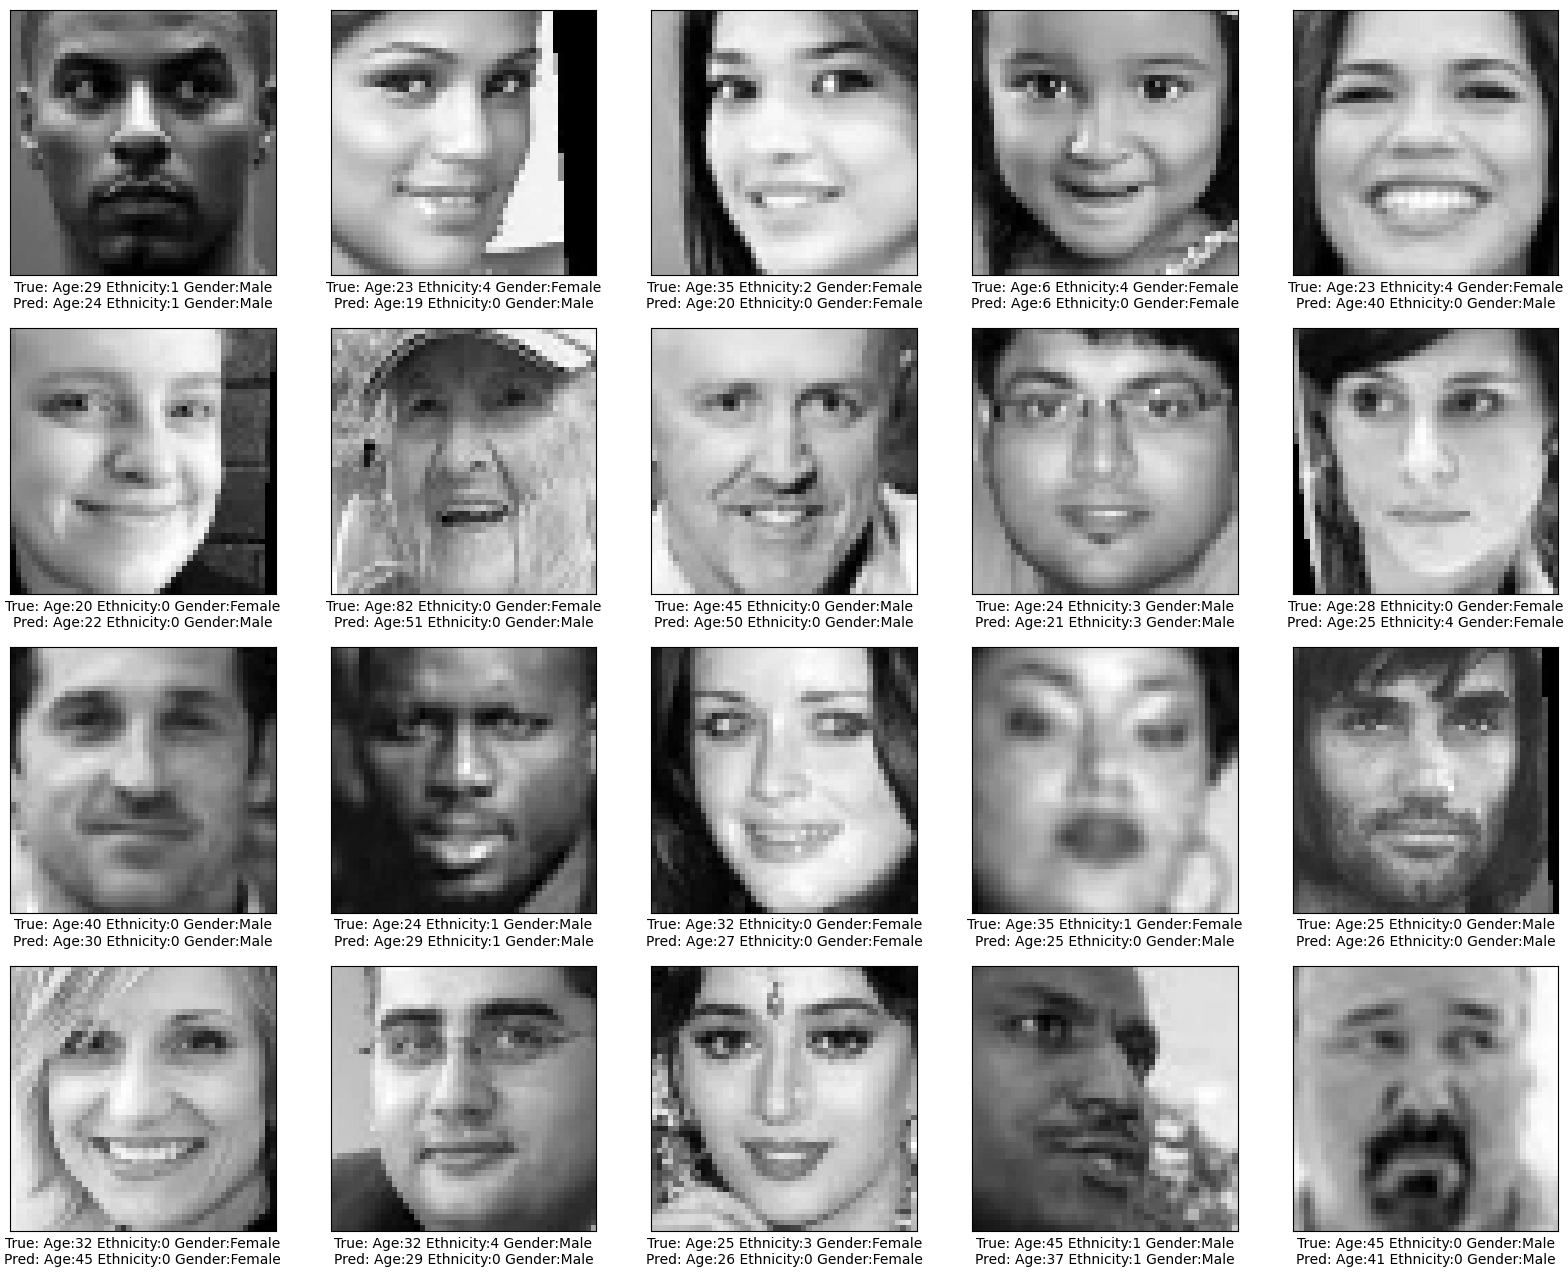

In [131]:
# baseline mulit-output model
# Define the number of images to display
num_images = 20
start_index = 1600  # Adjust this index to choose different images from the test set

plt.figure(figsize=(20, 20))

for i in range(num_images):
    idx = start_index + i
    img = test_images[idx].reshape(1, 48, 48, 1)

    # Making predictions
    predictions = model.predict(img, verbose=0)
    age_pred = predictions[0][0][0]  # Age prediction
    gender_pred = 1 if predictions[1][0][0] > 0.5 else 0  # Gender prediction
    ethnicity_pred = np.argmax(predictions[2][0])  # Ethnicity prediction

    # Determine true gender label
    true_gender_label = 'Female' if test_genders[idx] == 1 else 'Male'

    # Plotting
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[idx].reshape(48, 48), cmap='gray')
    plt.xlabel(
        f"True: Age:{test_ages[idx]} Ethnicity:{test_ethnicities[idx]} Gender:{true_gender_label}\n" +
        f"Pred: Age:{int(age_pred)} Ethnicity:{ethnicity_pred} Gender:{'Female' if gender_pred == 1 else 'Male'}"
    )

plt.show()


This model had a mediocre score in predicting ethnicity, but I would also have difficulty in labelling all these pictures correctly. The fact that dedicated model achieved better results is interesting. 

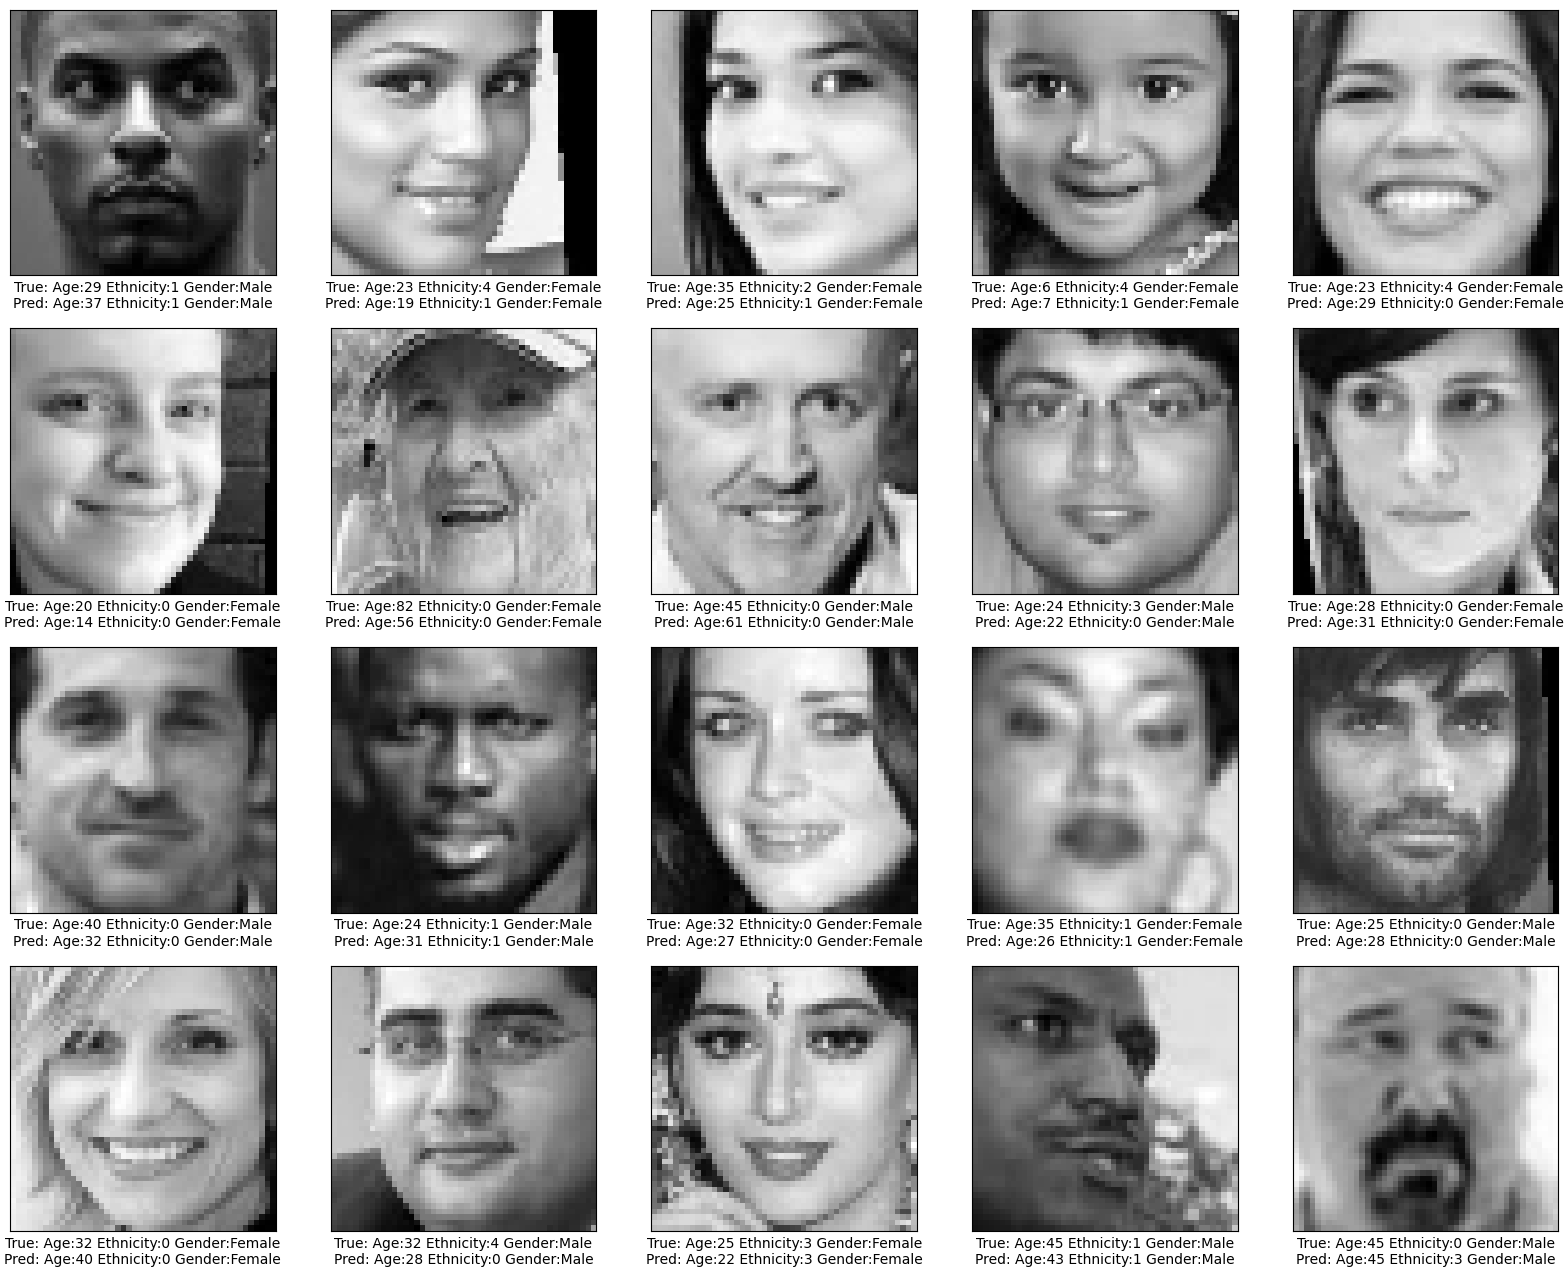

In [204]:
# task-dedicated models

# Define the number of images to display
num_images = 20
start_index = 1600  # Adjust this index to choose different images from the test set

plt.figure(figsize=(20, 20))

for i in range(num_images):
    idx = start_index + i
    img = test_images[idx].reshape(1, 48, 48, 1)

    # Making predictions using dedicated models
    age_pred = model_age.predict(img, verbose=0)[0][0]  # Age prediction
    gender_pred = model_gender.predict(img, verbose=0)[0][0]  # Gender prediction
    ethnicity_pred = np.argmax(model_eth.predict(img, verbose=0)[0])  # Ethnicity prediction

    # Determine true gender label
    true_gender_label = 'Female' if test_genders[idx] == 1 else 'Male'

    # Plotting
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[idx].reshape(48, 48), cmap='gray')
    plt.xlabel(
        f"True: Age:{test_ages[idx]} Ethnicity:{test_ethnicities[idx]} Gender:{true_gender_label}\n" +
        f"Pred: Age:{int(age_pred)} Ethnicity:{ethnicity_pred} Gender:{'Female' if gender_pred > 0.5 else 'Male'}"
    )

plt.show()



The most surprising result, in my opinion, was the accuracy of the age prediction; I personally could not tell the age of these people that accurately just by looking at them. 

# Conclusion
It was an interesting problem to explore and solve, I think a more sophisticated model with multiple outputs would work just as well as the dedicated models. Predicting age, ethnicity and gender is a real problem in surveillance and it is exciting to see that such simple models produced great results. As this was my first exposure to multi-output deep learning models and shared layers, there is certainly a lot of room for improvement. Probably extending the dedicated layers of each problem and increasing the complexity of the shared layers would have yielded better results. However, during my work I came to the conclusion that in order to perform more experiments with predictable and correct results, I would have to find a higher resolution, probably RGB dataset with preferably less mislabelled images. 
In the architecture of the dedicated models, I tried using machine learning techniques such as batch normalisation, weight initialisation, different activation functions, kernel regularisers and dropout. They all seemed to improve the models when used in the right place, and with some trial and error I was able to settle on a good combination of techniques and their influence on the architecture. There was no one-size-fits-all approach to improving the models, and all of the methods used required testing and time. In summary, it was a great learning experience and I'm glad I did it!  

## Plots of model architectures

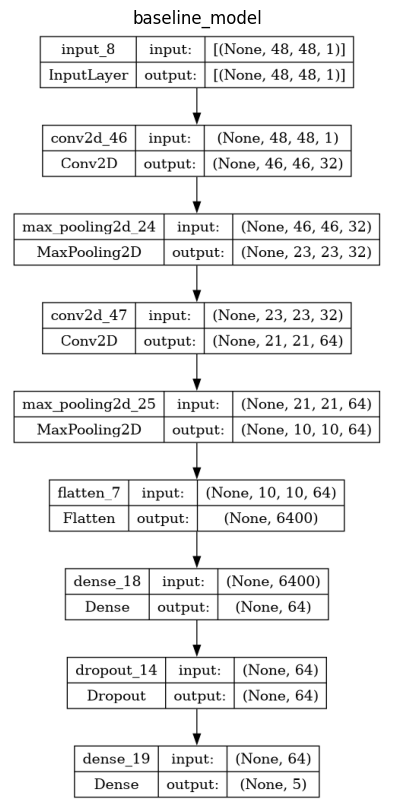

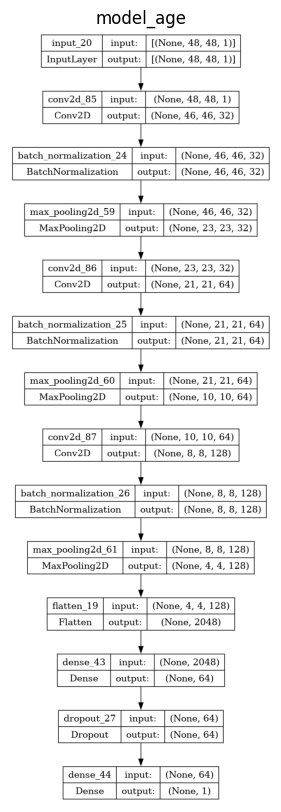

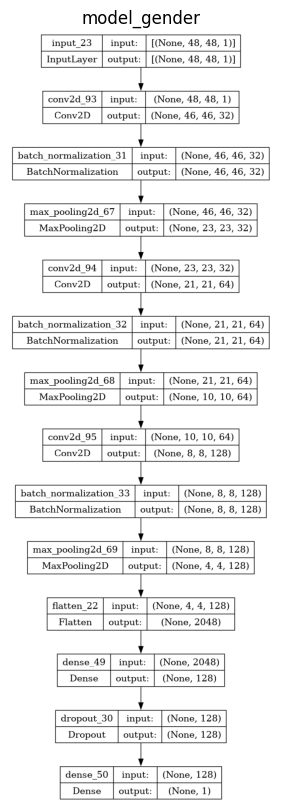

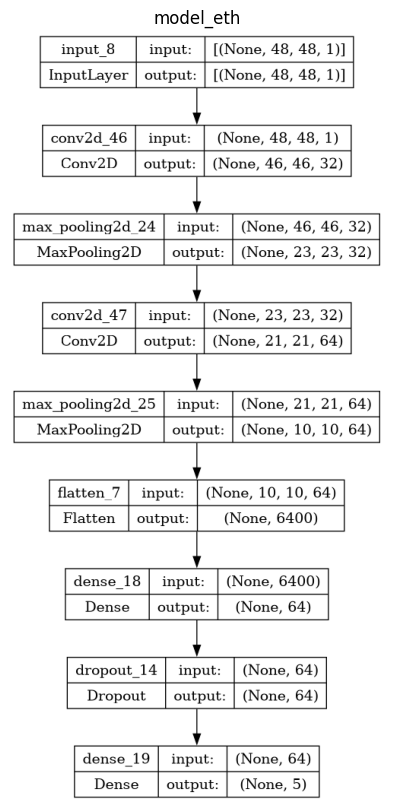

In [229]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Directory where the images will be saved
# os.mkdir('/kaggle/working/plots/')
save_dir = '/kaggle/working/plots/'

# Plot and save the architecture of each model
model_names = ['baseline_model', 'model_age', 'model_gender', 'model_eth']
models = [model, model_age, model_gender, model_eth]

for model_name, model in zip(model_names, models):
    plot_path = f'{save_dir}{model_name}.png'
    plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)
    
    # Display the plot
    img = mpimg.imread(plot_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(model_name)
    plt.show()

# for some reason plot of the multi-output model is not properly displayed in the notebook 